<a href="https://colab.research.google.com/github/stupidnameomg/practicing-deeptrack/blob/main/MEAN_VALUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3

import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import scipy.io as IO
import keras.backend as K
import keras.optimizers as optimizers
import os
from matplotlib import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
from cycler import cycler

#drive.mount('/content/gdrive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

     |████████████████████████████████| 80 kB 3.8 MB/s 
     |████████████████████████████████| 1.1 MB 37.3 MB/s 
Tue Feb  8 11:52:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------------

In [ ]:
IMAGE_SIZE = 128

particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE/2 + IMAGE_SIZE/50 * np.random.randn(), IMAGE_SIZE/2+IMAGE_SIZE/50*np.random.randn()),
    z=lambda: -150 + np.random.random() * 300,
    radius=lambda:1e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.3) + 1.37,
    L=8,
    position_unit="pixel",
)

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=23)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=635e-9,
    aperature_angle=53.7 * 2 * np.pi / 360,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil= HC + VC + CROP
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda level: np.random.rand() * 0.0,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.0j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 3e-4 * 0,
)

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

dataset = optics(particle + noise + gradient) + complex_to_float

In [ ]:
def get_label(image):
    return np.array([image.get_property("z")])

In [ ]:
PLOT_IMAGES = False

if PLOT_IMAGES:
  for i in range(4):
      dataset.update()
      image_of_particle = dataset.resolve()
      position_of_particle = image_of_particle.get_property("position")
      
      plt.figure(figsize=(10,5))
      plt.subplot(1,2,1)
      plt.imshow(image_of_particle[:, :, 0], cmap="gray")
      plt.scatter(position_of_particle[1], position_of_particle[0], s=120, facecolors='none', edgecolors="g", linewidth=2)
      
      plt.subplot(1,2,2)
      plt.imshow(image_of_particle[:, :, 1], cmap="gray")
      plt.show()


## 3. Defining the network

The network used is a Convolutional network, with a the pixel error as loss.

In [ ]:
convlayers = [(32, 64, 128, 128, 128)]
denselayers  =[(32, 32)]
dropouts = [(0.2, 0.2, 0.2, 0.2, 0.2)]
optimizers = ["adam"]
models = []

for _ in range(10):
  for conv in convlayers:
    for dense in denselayers:
      for drop in dropouts:
        for optim in optimizers:
          model = dt.models.Convolutional(
              input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
              conv_layers_dimensions=conv,
              dense_layers_dimensions=dense,
              steps_per_pooling=2,
              number_of_outputs=1,
              dropout=drop,
              loss="mae",
              optimizer=optim,
              dense_block=dt.layers.DenseBlock(activation="relu")
          )
          models.append(model)
          model.totalhistory = {"val_loss":[], "loss":[]}

print(f"Number of models to be trained:{len(models) }")


Number of models to be trained:10


In [ ]:
def save_progress(h, validation_set, validation_labels, model, plot=True):
    model.totalhistory["val_loss"].extend(h.history["val_loss"])
    model.totalhistory["loss"].extend(h.history["loss"])            
    if plot:
        validation_predictions = model.predict(np.array(validation_set))
        worst_image_index = np.argmax(np.abs(validation_predictions-np.array(validation_labels)))
        worst_selected_image = validation_set[worst_image_index]
        worst_actual_z = worst_selected_image.get_property("z")
        worst_predicted_z = validation_predictions[worst_image_index,0]

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8))

        ax1.plot(model.totalhistory["val_loss"], 'g', label="validation loss")
        ax1.plot(model.totalhistory["loss"], 'b', label="training loss")
        ax1.set_xlabel("Epoch")
        ax1.set_yscale('log')
        ax1.legend()

        ax2.plot(validation_predictions, validation_labels, 'r.')
        ax2.plot(np.linspace(-150,150),np.linspace(-150,150),'k')
        ax2.set_xlabel("predicted z")
        ax2.set_ylabel("actual z")

        ax3.hist(validation_predictions-np.array(validation_labels), bins=list(np.linspace(-10,10)))
        ax3.set_xlabel("Pixlar från faktiskt värde")

        ax4.set_title("The least well predicted picture from validation_set")
        ax4.set_xlabel(f"Predicted z: {worst_predicted_z:.2f}, Actual z: {worst_actual_z:.2f}")
        ax4.imshow(worst_selected_image[:,:,0], cmap="gray")

        plt.show()

def plot_together(models):
    cc = (cycler(color=list('bgrcmyk')) +
      cycler(linestyle=['-', '--', '-.', ':', '-', '--', '-.']))
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(model.totalhistory["loss"], label=f"Model {i}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Training loss")
        ax.legend()
    plt.show()

## 4. Training the network

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


Generating 2562 / 2560 samples before starting training
Model 0: <keras.optimizer_v2.adam.Adam object at 0x7fd550a54f10>


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


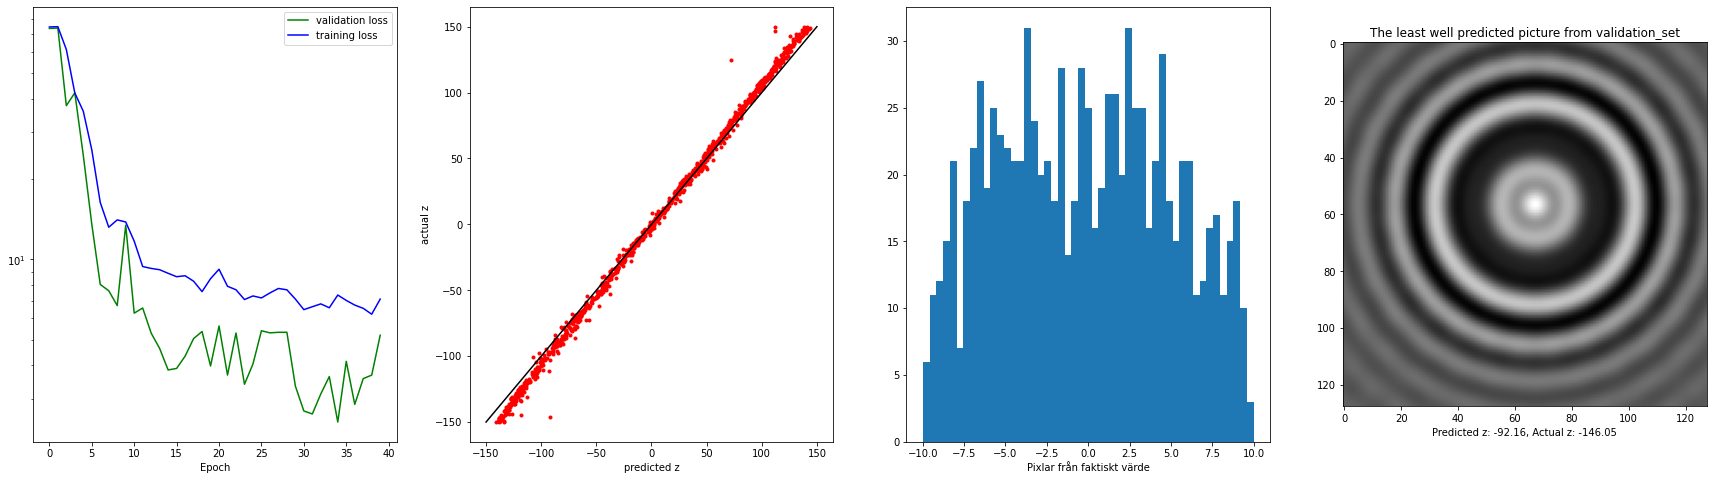

Model 1: <keras.optimizer_v2.adam.Adam object at 0x7fd550938490>


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


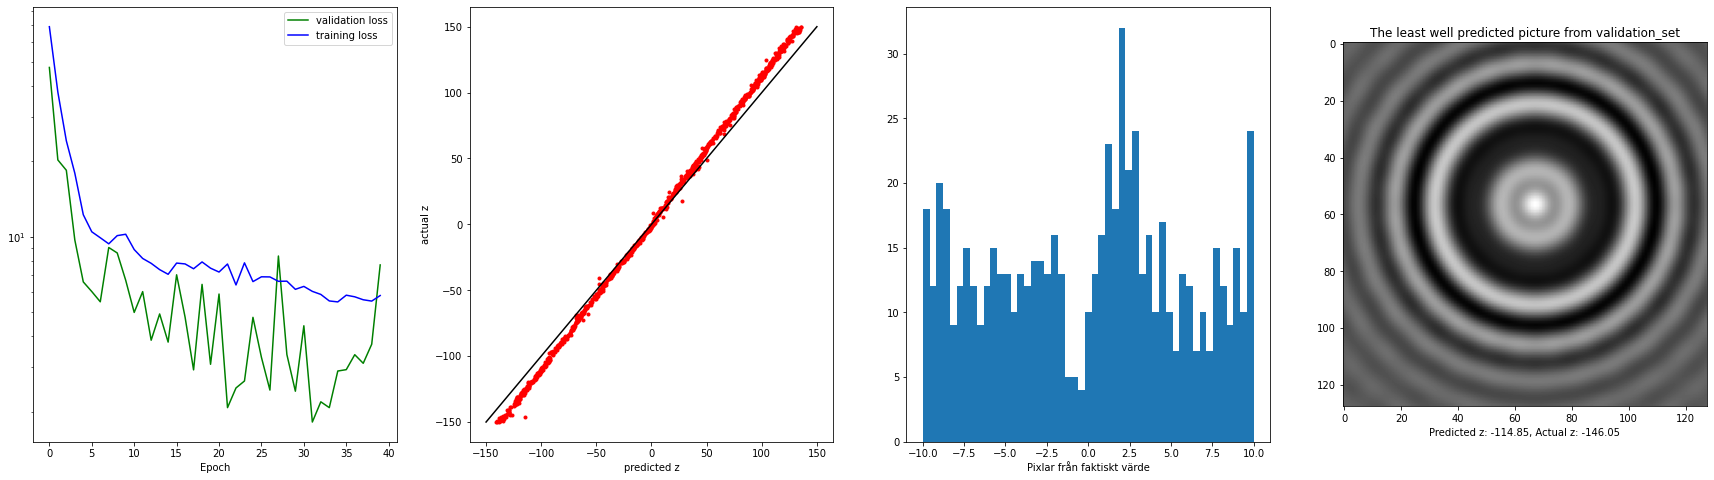

Model 2: <keras.optimizer_v2.adam.Adam object at 0x7fd55090a390>


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


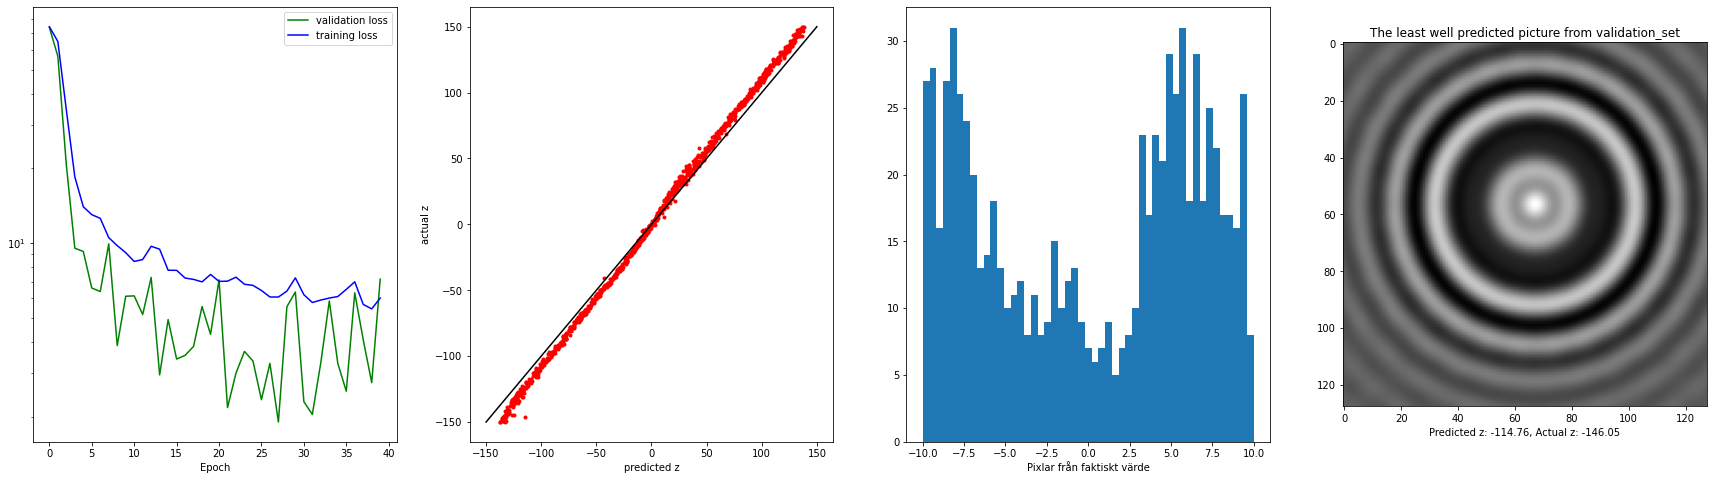

Model 3: <keras.optimizer_v2.adam.Adam object at 0x7fd5508935d0>


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


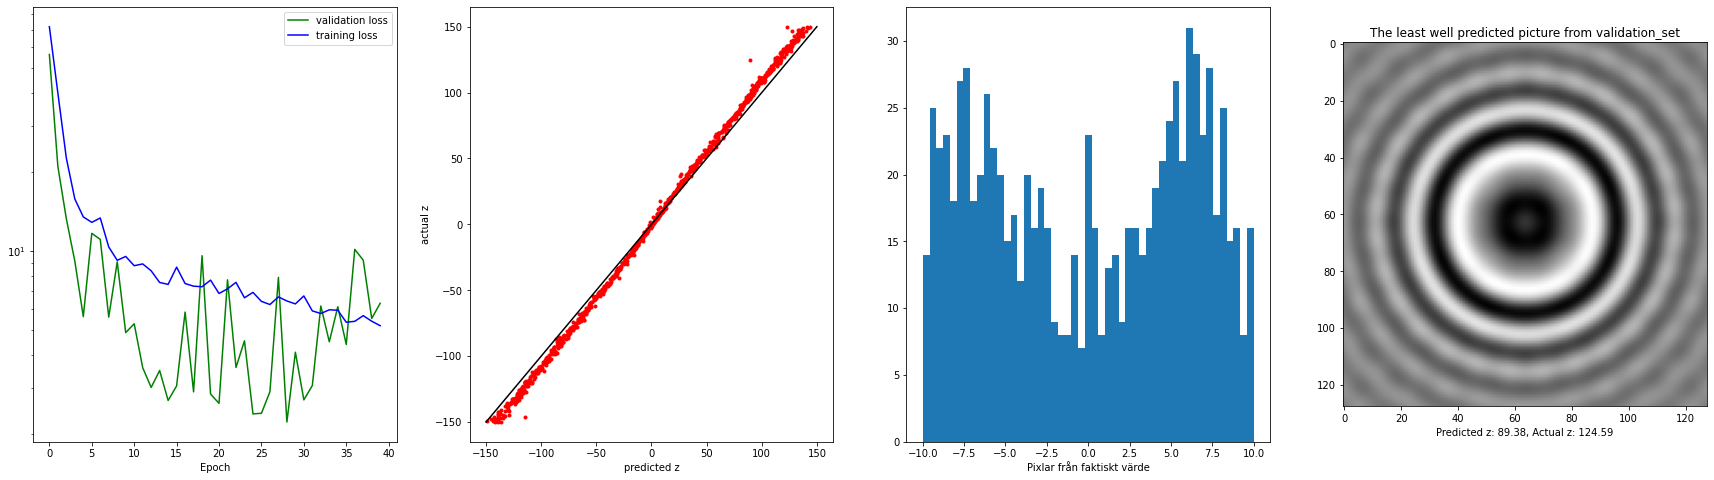

Model 4: <keras.optimizer_v2.adam.Adam object at 0x7fd55081ded0>


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


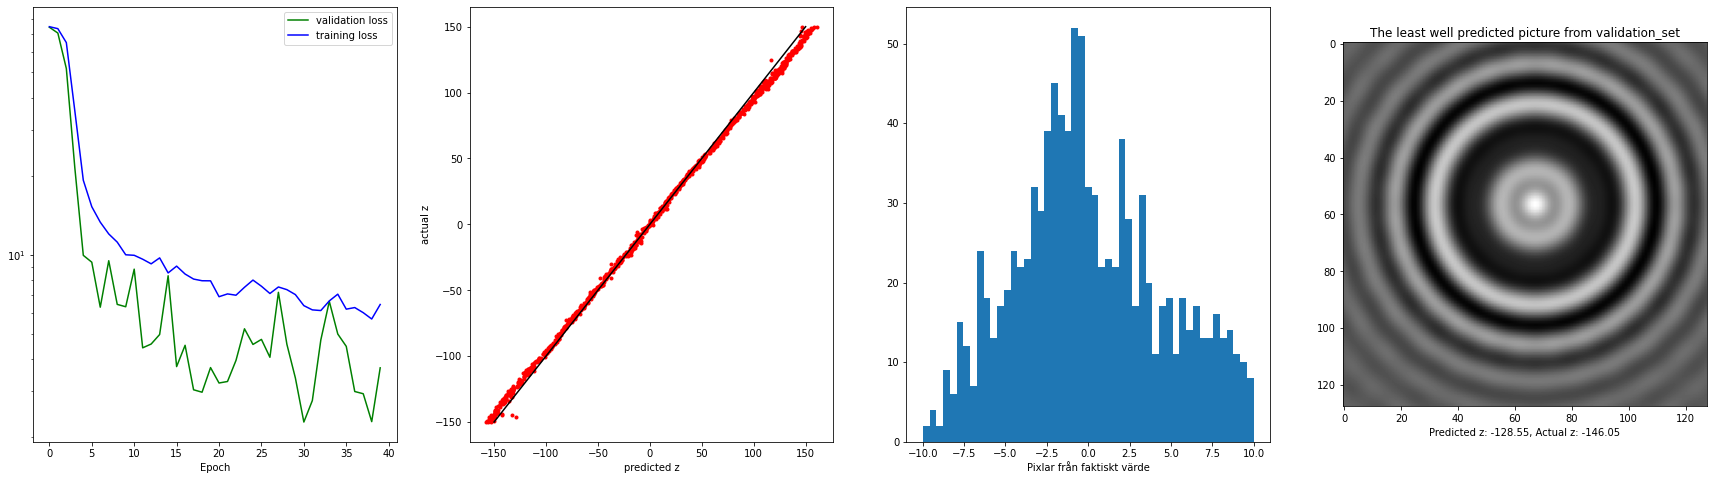

Model 5: <keras.optimizer_v2.adam.Adam object at 0x7fd550832f10>


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


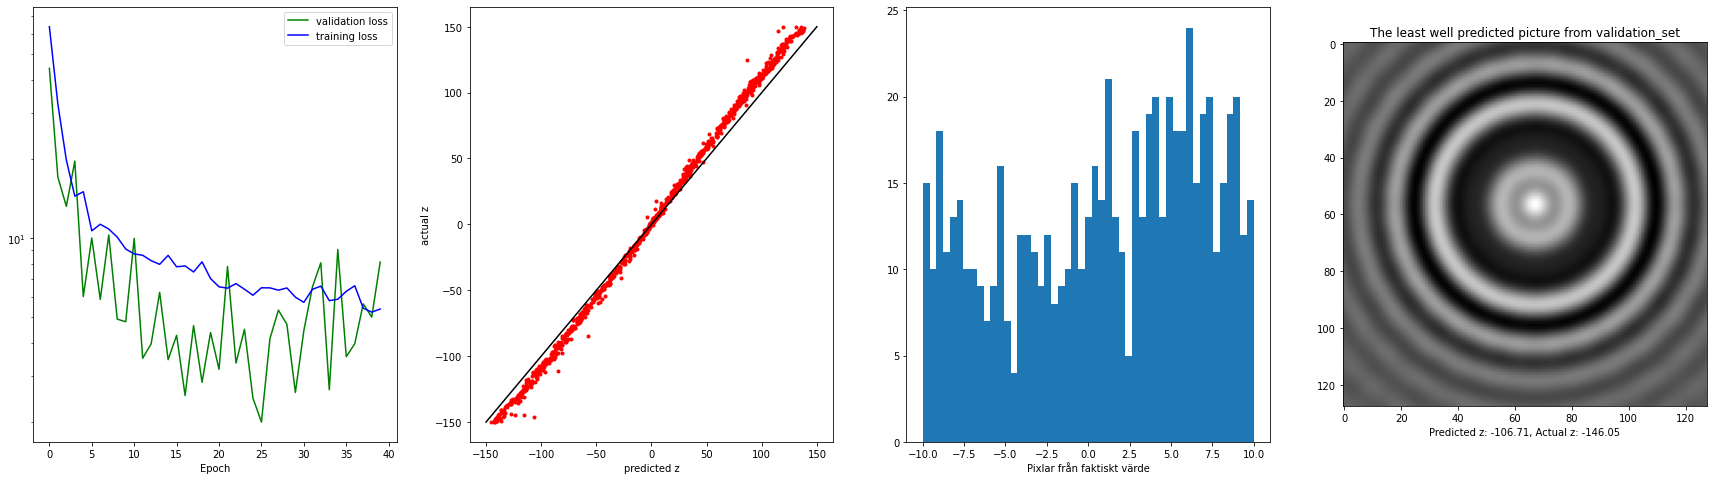

Model 6: <keras.optimizer_v2.adam.Adam object at 0x7fd550747990>


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


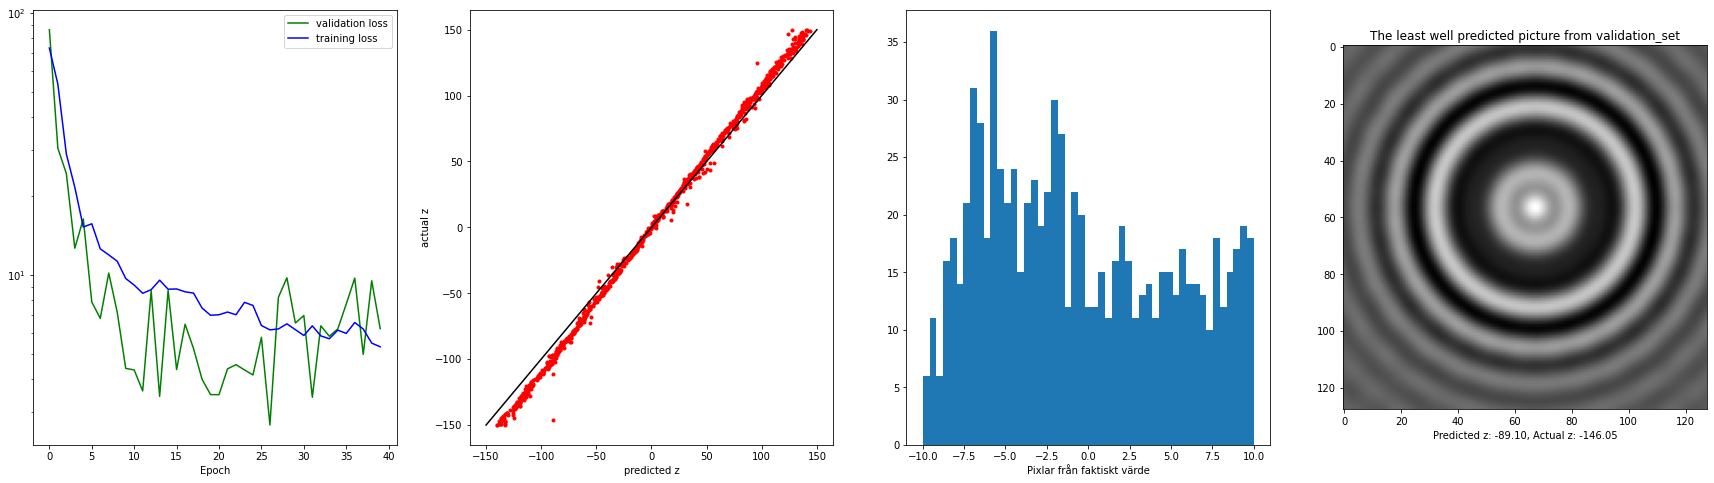

In [ ]:
#checkpoint_path = "START/firstmodel.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

TRAIN_MODEL = True

validation_set_size = 1024
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]


generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=512*5,
    max_data_size=512*6,
    batch_size=128
)

with generator:
    for i, model in enumerate(models):
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            epochs=40,
            verbose=1,
        )
        print(f'Model {i}:', model.optimizer)
        save_progress(h, validation_set, validation_labels, model, plot=True)

    plot_together(models)
    #images_dir = '/content/gdrive/My Drive/Images'
    #plt.savefig(f"{images_dir}/{i}.png")

In [ ]:

one_model = models[0]

def mean(img):
  outputs = []
  for model in models:
    guess = model.predict(img)[0][0]
    outputs.append(guess)
  big_guess = np.sum(outputs)/len(models)
  return big_guess

score_one = 0
score_mean = 0

TEST = 10

for i in range(TEST):
    dataset.update()
    img = dataset.resolve()

    img = img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 2)

    one_guess = one_model.predict(img)[0][0]
    mean_guess = mean(img)

    correct = get_label(img)[0]

    one_error = np.abs(correct-one_guess)
    mean_error = np.abs(correct-mean_guess)

    score_one += one_error
    score_mean += mean_error

score_one = score_one/TEST
score_mean = score_mean/TEST

print(score_one)
print(score_mean)







  

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


88.98728480908713
88.98741662064654
